In [1]:
library(igraph)
library(spectralGraphTopology)
library(sparseGraph)
library(matrixStats)
library(latex2exp)
library(scales)
set.seed(123)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘spectralGraphTopology’


The following object is masked from ‘package:stats’:

    D


Warning message:
“package ‘scales’ was built under R version 3.6.2”


In [2]:
# number of nodes
p <- 100
# generate a grid graph
pm <- cbind(c(.05, .001, .001, .001), c(.001, .05, .001, .001),
            c(.001, .001, .05, .001), c(.001, .001, .001, .05))
true_graph <- sample_sbm(p, pref.matrix=5*pm, block.sizes=c(25,25,25,25))
E(true_graph)$weight <- runif(gsize(true_graph), min = 2, max = 5)
# Get the true Laplacian matrices
Ltrue <- as.matrix(laplacian_matrix(true_graph))

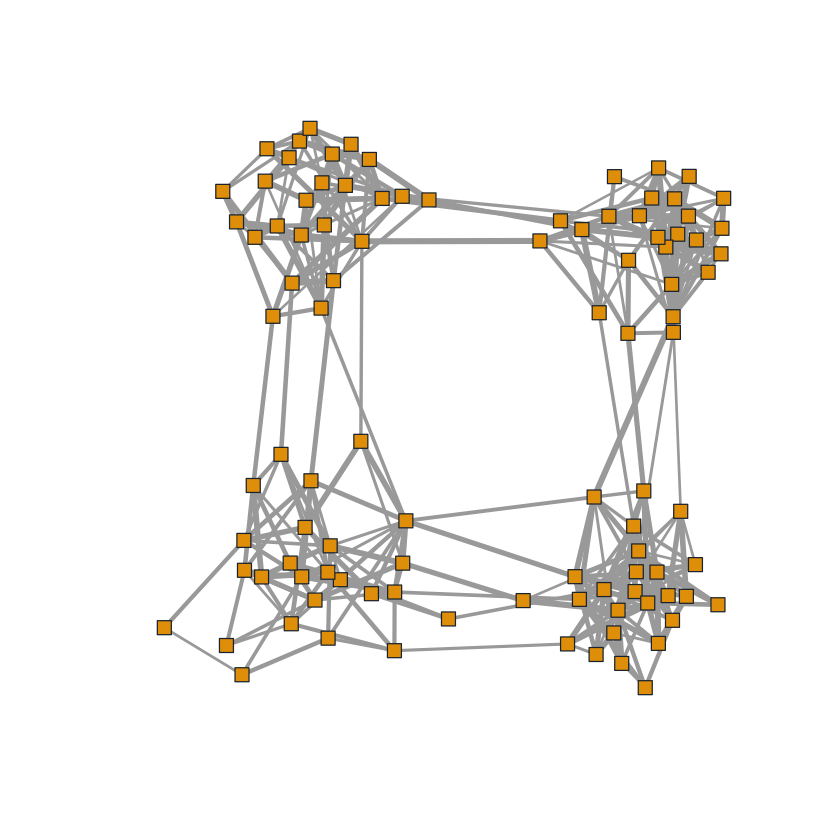

In [3]:
plot(true_graph, vertex.frame.color = "#222f3e",
     vertex.label = NA, vertex.size = 5, vertex.shape = 'square', edge.width=E(true_graph)$weight)

# Monte Carlo results

In [4]:
n_edges <- .5 * sum(Ltrue < 0)
ratios <- c(10, 50, 100., 250, 500, 1000)
alphas_scad <- c(5e-4, 1e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1)
alphas_mcp <- c(1e-3, 5e-2, 1e-1, 1.5e-1, 1.75e-1, 2.5e-1)
n_ratios <- c(1:length(ratios))

In [8]:
n_realizations <- 100
nonzero_edges_admm <- matrix(0, length(n_ratios), n_realizations)
re_admm <- matrix(0, length(n_ratios), n_realizations)
fs_admm <- matrix(0, length(n_ratios), n_realizations)
nonzero_edges_pgd <- matrix(0, length(n_ratios), n_realizations)
re_pgd <- matrix(0, length(n_ratios), n_realizations)
abse_pgd <- matrix(0, length(n_ratios), n_realizations)
fs_pgd <- matrix(0, length(n_ratios), n_realizations)
nonzero_edges_scad <- matrix(0, length(n_ratios), n_realizations)
re_scad <- matrix(0, length(n_ratios), n_realizations)
fs_scad <- matrix(0, length(n_ratios), n_realizations)
algcon_scad <- matrix(0, length(n_ratios), n_realizations)
nonzero_edges_mcp <- matrix(0, length(n_ratios), n_realizations)
re_mcp <- matrix(0, length(n_ratios), n_realizations)
fs_mcp <- matrix(0, length(n_ratios), n_realizations)

In [9]:
for (k in c(1:length(ratios))) {
    for (n in c(1:n_realizations)) {
        X <- MASS::mvrnorm(ratios[k] * p, mu = rep(0, p), Sigma = MASS::ginv(Ltrue))
        # Compute the sample covariance matrix
        S <- cov(X)
        # Estimate a graph from the samples using ADMM
        graph_admm <- learn_laplacian_gle_admm(S = S, alpha = 0, reltol = 1e-7, verbose = FALSE)
        nonzero_edges_admm[k,n] <- nonzero_edges_admm[k,n] + .5 * sum(graph_admm$Adjacency > 1e-5)
        re_admm[k,n] <- re_admm[k,n] + relative_error(graph_admm$Laplacian, Ltrue)
        fs_admm[k,n] <- fs_admm[k,n] + fscore(Ltrue, graph_admm$Laplacian, 1e-5)
        # Estimate a graph from the samples using PGD
        graph_pgd <- learn_laplacian_pgd_connected(S = S, alpha = 0, verbose = FALSE)
        nonzero_edges_pgd[k,n] <- nonzero_edges_pgd[k,n] + .5 * sum(graph_pgd$adjacency > 1e-5)
        re_pgd[k,n] <- re_pgd[k,n] + relative_error(graph_pgd$laplacian, Ltrue)
        fs_pgd[k,n] <- fs_pgd[k,n] + fscore(Ltrue, graph_pgd$laplacian, 1e-5)
                           
        # Estimate a graph from the samples using SCAD
        graph_scad <- learn_laplacian_pgd_connected(S = S, alpha = alphas_scad[k], gamma = 2.001,
                                                    sparsity_type = "scad", verbose = FALSE)
        nonzero_edges_scad[k,n] <- nonzero_edges_scad[k,n] + .5 * sum(graph_scad$adjacency > 0)
        re_scad[k,n] <- re_scad[k,n] + relative_error(graph_scad$laplacian, Ltrue)
        fs_scad[k,n] <- fs_scad[k,n] + fscore(Ltrue, graph_scad$laplacian, 1e-5)
        # Estimate a graph from the samples using MCP
        graph_mcp <- learn_laplacian_pgd_connected(S = S, alpha = alphas_mcp[k], gamma = 1.001,
                                                   sparsity_type = "mcp", verbose = FALSE)
        nonzero_edges_mcp[k,n] <- nonzero_edges_mcp[k,n] + .5 * sum(graph_mcp$adjacency > 1e-5)
        re_mcp[k,n] <- re_mcp[k,n] + relative_error(graph_mcp$laplacian, Ltrue)
        fs_mcp[k,n] <- fs_mcp[k,n] + fscore(Ltrue, graph_mcp$laplacian, 1e-5)
    }
}

In [10]:
avg_re_admm <- rowMeans(re_admm)
sd_re_admm <- rowSds(re_admm)
avg_re_pgd <- rowMeans(re_pgd)
sd_re_pgd <- rowSds(re_pgd)
avg_re_scad <- rowMeans(re_scad)
sd_re_scad <- rowSds(re_scad)
avg_re_mcp <- rowMeans(re_mcp)
sd_re_mcp <- rowSds(re_mcp)

In [11]:
avg_fs_admm <- rowMeans(fs_admm)
sd_fs_admm <- rowSds(fs_admm)
avg_fs_pgd <- rowMeans(fs_pgd)
sd_fs_pgd <- rowSds(fs_pgd)
avg_fs_scad <- rowMeans(fs_scad)
sd_fs_scad <- rowSds(fs_scad)
avg_fs_mcp <- rowMeans(fs_mcp)
sd_fs_mcp <- rowSds(fs_mcp)

In [12]:
avg_nonzero_edges_admm <- rowMeans(nonzero_edges_admm)
sd_nonzero_edges_admm <- rowSds(nonzero_edges_admm)
avg_nonzero_edges_pgd <- rowMeans(nonzero_edges_pgd)
sd_nonzero_edges_pgd <- rowSds(nonzero_edges_pgd)
avg_nonzero_edges_scad <- rowMeans(nonzero_edges_scad)
sd_nonzero_edges_scad <- rowSds(nonzero_edges_scad)
avg_nonzero_edges_mcp <- rowMeans(nonzero_edges_mcp)
sd_nonzero_edges_mcp <- rowSds(nonzero_edges_mcp)

In [13]:
gr <- .5 * (1 + sqrt(5))
labels <- c("10", "50", "100", "250", "500", "1000")
legend <- c("NGL-SCAD (proposed)", "NGL-MCP (proposed)", "GLE-ADMM (benchmark)",  TeX("PGD-l$_1$-norm (baseline)"))
pch <- c(19, 17, 18, 15)
lty <- c(1, 1, 1, 1)
colors <- c("#1B1464", "#ED4C67", "#38ada9", "#6F1E51")
cex <- 1.1
lwd <- 2

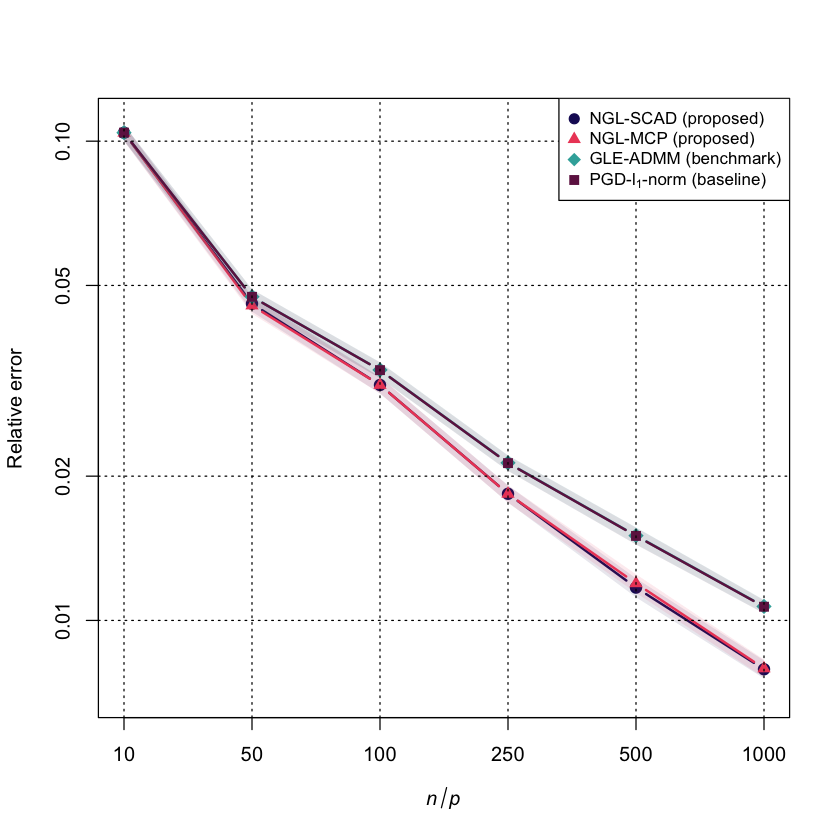

In [15]:
#setEPS()
#cairo_pdf("modular-relative-error-sample-size.pdf", family = "Palatino", height = 7,
#         width = 7, pointsize = 18)
plot(n_ratios, avg_re_scad, xlab = TeX("$\\mathit{n / p}$"), ylim = c(0.007, .11),
     ylab = "Relative error", type = "b",
     pch=pch[1], lty=lty[1], cex=cex, col = colors[1], xaxt = "n", lwd=lwd, log='y')
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_re_scad - sd_re_scad,
                                              rev(avg_re_scad + sd_re_scad)),
        col = alpha(colors[1], alpha = .1), border = NA)
lines(n_ratios, avg_re_mcp, type = "b", pch=pch[2], lty=lty[2], cex=cex, col = colors[2], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_re_mcp - sd_re_mcp, rev(avg_re_mcp + sd_re_mcp)),
        col = alpha(colors[2], alpha = .1), border = NA)
lines(n_ratios, avg_re_admm, type = "b", pch=pch[3], lty=lty[3], cex=1.7, col = colors[3], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_re_admm - sd_re_admm, rev(avg_re_admm + sd_re_admm)),
        col = alpha(colors[3], alpha = .1), border = NA)
lines(n_ratios, avg_re_pgd, type = "b", pch=pch[4], lty=lty[4], cex=cex, col = colors[4], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_re_pgd - sd_re_pgd, rev(avg_re_pgd + sd_re_pgd)),
        col = alpha(colors[4], alpha = .1), border = NA)
grid(col="black", equilogs=FALSE)
axis(side = 1, at = n_ratios, labels = labels)
legend("topright", legend=legend, col=colors, pch=pch, box.lty=1, bg="white", cex = .85,
       pt.cex = c(1.1, 1.1, 1.5, 1.1))
#dev.off()

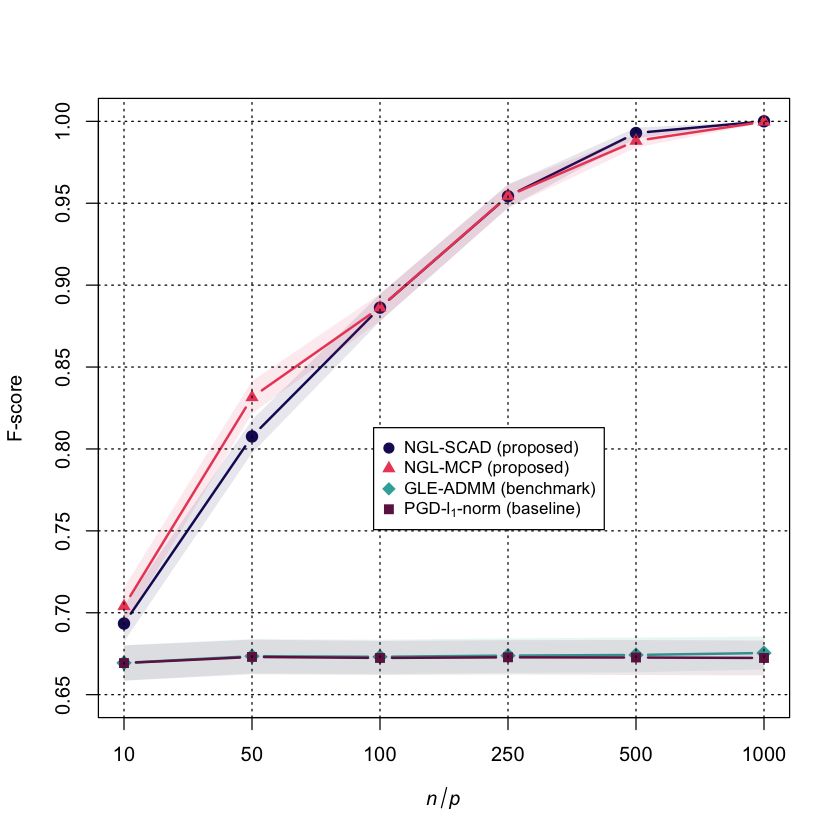

In [16]:
#setEPS()
#cairo_pdf("modular-fscore-sample-size.pdf", family = "Palatino", height = 7,
#         width = 7, pointsize = 18)
plot(n_ratios, avg_fs_scad, xlab = TeX("$\\mathit{n / p}$"), ylim = c(.65, 1), ylab = "F-score", type = "b",
     pch=pch[1], lty=lty[1], cex=cex, col = colors[1], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_fs_scad - sd_fs_scad, rev(avg_fs_scad + sd_fs_scad)),
        col = alpha(colors[1], alpha = .1), border = NA)
lines(n_ratios, avg_fs_mcp, type = "b", pch=pch[2], lty=lty[2], cex=cex, col = colors[2], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_fs_mcp - sd_fs_mcp, rev(avg_fs_mcp + sd_fs_mcp)),
        col = alpha(colors[2], alpha = .1), border = NA)
lines(n_ratios, avg_fs_admm, type = "b", pch=pch[3], lty=lty[3], cex=1.7, col = colors[3], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_fs_admm - sd_fs_admm, rev(avg_fs_admm + sd_fs_admm)),
        col = alpha(colors[3], alpha = .1), border = NA)
lines(n_ratios, avg_fs_pgd, type = "b", pch=pch[4], lty=lty[4], cex=cex, col = colors[4], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_fs_pgd - sd_fs_pgd, rev(avg_fs_pgd + sd_fs_pgd)),
        col = alpha(colors[4], alpha = .1), border = NA)
grid(col="black")
axis(side = 1, at = n_ratios, labels = labels)
legend(2.95, 0.813, legend=legend, col=colors, pch=pch, bg = "white", box.lty=1, cex = .85,
       pt.cex = c(1.1, 1.1, 1.5, 1.1))
#dev.off()

In [17]:
yaxis <- c(344, 400, 500, 600, 700)

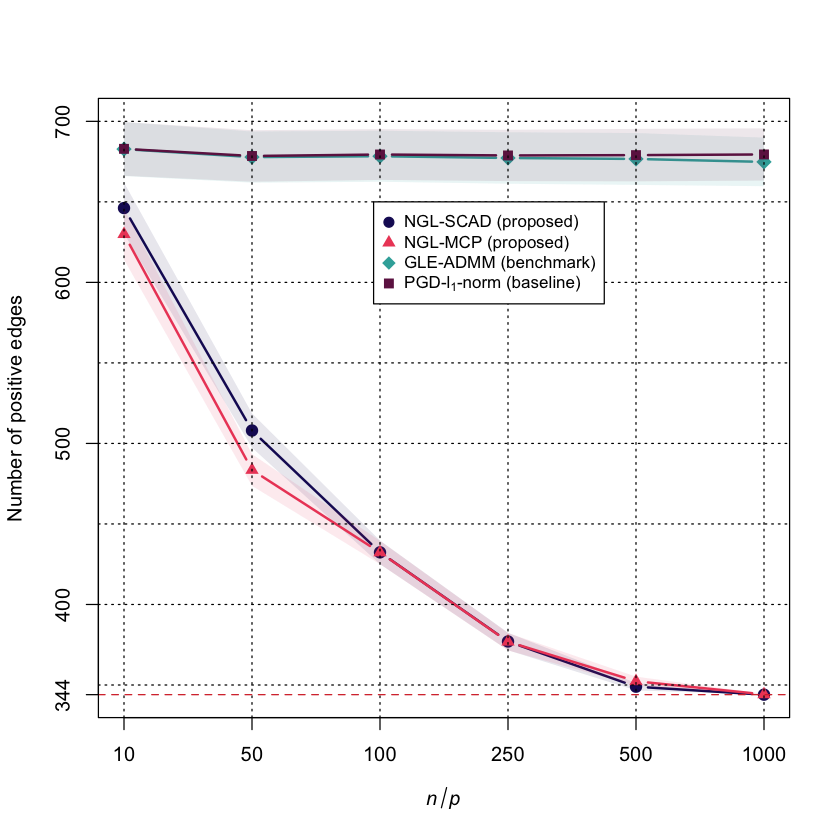

In [18]:
#setEPS()
#cairo_pdf("modular-number-of-positive-edges-sample-size.pdf", family = "Palatino", height = 7,
#         width = 7, pointsize = 18)
plot(n_ratios, avg_nonzero_edges_scad, xlab = TeX("$\\mathit{n / p}$"), ylim = c(344, 700), ylab = "Number of positive edges", type = "b",
     pch=pch[1], lty=lty[1], cex=cex, col = colors[1], xaxt = "n", yaxt='n', lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_nonzero_edges_scad - sd_nonzero_edges_scad,
                                              rev(avg_nonzero_edges_scad + sd_nonzero_edges_scad)),
        col = alpha(colors[1], alpha = .1), border = NA)
lines(n_ratios, avg_nonzero_edges_mcp, type = "b", pch=pch[2], lty=lty[2], cex=cex, col = colors[2], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_nonzero_edges_mcp - sd_nonzero_edges_mcp,
                                              rev(avg_nonzero_edges_mcp + sd_nonzero_edges_mcp)),
        col = alpha(colors[2], alpha = .1), border = NA)
lines(n_ratios, avg_nonzero_edges_admm, type = "b", pch=pch[3], lty=lty[3], cex=1.7, col = colors[3], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_nonzero_edges_admm - sd_nonzero_edges_admm,
                                              rev(avg_nonzero_edges_admm + sd_nonzero_edges_admm)),
        col = alpha(colors[3], alpha = .1), border = NA)
lines(n_ratios, avg_nonzero_edges_pgd, type = "b", pch=pch[4], lty=lty[4], cex=cex, col = colors[4], xaxt = "n", lwd=lwd)
polygon(x = c(n_ratios, rev(n_ratios)), y = c(avg_nonzero_edges_pgd - sd_nonzero_edges_pgd,
                                              rev(avg_nonzero_edges_pgd + sd_nonzero_edges_pgd)),
        col = alpha(colors[4], alpha = .1), border = NA)
grid(col="black")
abline(h=344, col="#d63031", lty=2)
axis(side = 1, at = n_ratios, labels = labels)
axis(side = 2, at = yaxis, labels = yaxis)
legend(2.95, 650, legend=legend, col=colors, pch=pch, bg = "white", box.lty=1, cex = .85,
       pt.cex = c(1.1, 1.1, 1.5, 1.1))
#dev.off()